In [1]:
import os
import datetime

def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%mM:%S')
    print('\n' + '=====' * 8 + '%s' %nowtime)

# os.environ('KMP_DUPLICATE_LIB_OK') = 'True'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchkeras import summary
%matplotlib inline

## 准备数据

In [3]:
dftrain_raw = pd.read_csv('input/train.csv')
dftest_raw = pd.read_csv('input/test.csv')
dftrain_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- Survived: 0代表死亡, 1代表存活【y标签】
- Pclass: 乘客所持票类，有三种值(1, 2, 3)【转换成onehot编码】
- Name: 乘客姓名 【舍去】
- Sex: 乘客性别 【转换成bool特征】
- Age: 乘客年龄(有缺失)【数值特征, 添加"年龄是否缺失"作为辅助特征】
- SibSp: 乘客兄弟姐妹/配偶的个数(整数值)【数值特征】
- Parch: 乘客父母/孩子的个数(整数值)【数值特征】
- Ticket: 票号(字符串)【舍去】
- Fare: 乘客所持票的价格(浮点数, 0-500不等)【数值特征】
- Cabin: 乘客所在船舱(有缺失) 【添加"所在船舱是否缺失"作为辅助特征】
- Embarked: 乘客登船港口, S, C, Q(有缺失)【转换成onehot编码, 四维度 S, C, Q, nan

label分布情况

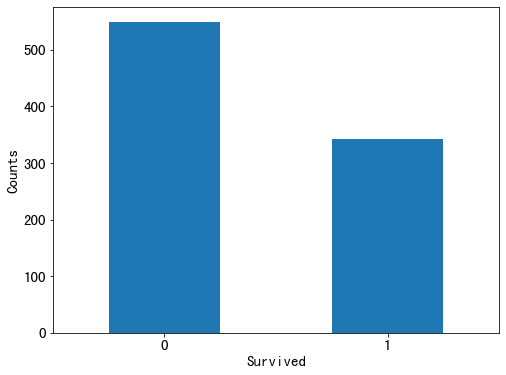

In [4]:
ax = dftrain_raw['Survived'].value_counts().plot(kind='bar', figsize=(8, 6), fontsize=15, rot=0)
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('Survived', fontsize=15)
plt.show()

年龄分布情况

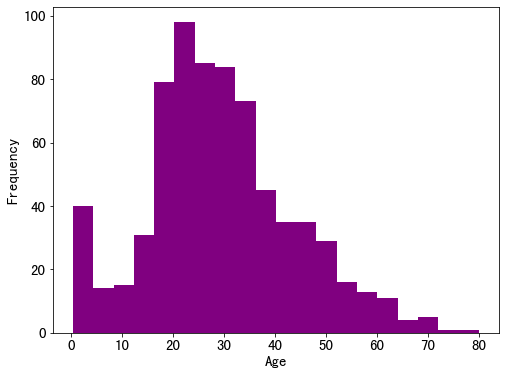

In [5]:
ax = dftrain_raw['Age'].plot(kind='hist', bins=20, color='purple', figsize=(8, 6), fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
ax.set_xlabel('Age', fontsize=15)
plt.show()

年龄与label的关系

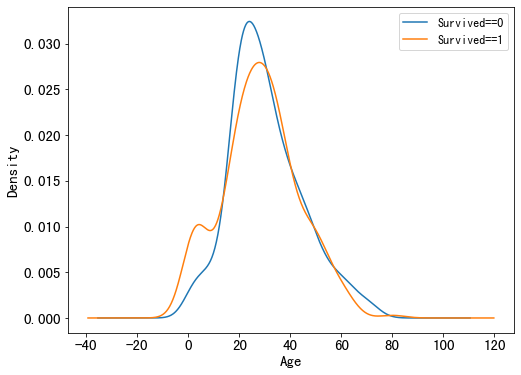

In [6]:
ax = dftrain_raw.query('Survived == 0')['Age'].plot(
    kind='density',
    figsize=(8, 6),
    fontsize=15
)
dftrain_raw.query('Survived == 1')['Age'].plot(
    kind='density',
    figsize=(8, 6),
    fontsize=15
)
ax.legend(['Survived==0', 'Survived==1'], fontsize=12)
ax.set_ylabel('Density', fontsize = 15)
ax.set_xlabel('Age', fontsize = 15)
plt.show()

In [7]:
def preprocessing(dfdata):

    dfresult= pd.DataFrame()

    # Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_' + str(x) for x in dfPclass.columns ]
    dfresult = pd.concat([dfresult, dfPclass], axis=1)

    # Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult, dfSex], axis=1)

    # Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')

    # SibSp, Parch, Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']

    # Carbin
    dfresult['Cabin_null'] =  pd.isna(dfdata['Cabin']).astype('int32')

    # Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'], dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult, dfEmbarked], axis=1)

    return dfresult


x_train = preprocessing(dftrain_raw).values
y_train = dftrain_raw[['Survived']].values

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)

x_test = preprocessing(dftest_raw).values
# y_test = dftest_raw[['Survived']].values

print("x_train.shape =", x_train.shape)
print("x_valid.shape =", x_valid.shape)
print("x_test.shape  =", x_test.shape)

print("y_train.shape =", y_train.shape)
print("y_valid.shape =", y_valid.shape)

x_train.shape = (712, 15)
x_valid.shape = (179, 15)
x_test.shape  = (418, 15)
y_train.shape = (712, 1)
y_valid.shape = (179, 1)


In [8]:
dl_train = DataLoader(TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).float()),
                      shuffle=True, batch_size=8)
dl_valid = DataLoader(TensorDataset(torch.tensor(x_valid).float(), torch.tensor(y_valid).float()),
                      shuffle=False, batch_size=8)

for features, labels in dl_train:
    print(features, labels)
    break

tensor([[ 0.0000,  1.0000,  0.0000,  0.0000,  1.0000, 33.0000,  0.0000,  0.0000,
          0.0000, 12.2750,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 1.0000,  0.0000,  0.0000,  1.0000,  0.0000, 22.0000,  0.0000,  0.0000,
          2.0000, 49.5000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  1.0000, 21.0000,  0.0000,  0.0000,
          0.0000,  8.4333,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  1.0000,  0.0000, 28.0000,  0.0000,  1.0000,
          1.0000, 14.4000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  1.0000, 29.0000,  0.0000,  1.0000,
          0.0000, 27.7208,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  1.0000, 25.0000,  0.0000,  1.0000,
          2.0000, 41.5792,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  0.0000,  0.0000,  0.0000,  1.0000, 51.0000,  0.0000,  0.0

## 定义网络

In [9]:
def create_net():
    net = nn.Sequential()
    net.add_module('linear1', nn.Linear(15, 20))
    net.add_module('relu1', nn.ReLU())
    net.add_module('linear2', nn.Linear(20, 15))
    net.add_module('relu2', nn.ReLU())
    net.add_module('linear3', nn.Linear(15, 1))
    net.add_module('sigmoid', nn.Sigmoid())
    return net

net = create_net()
print(net)

Sequential(
  (linear1): Linear(in_features=15, out_features=20, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=20, out_features=15, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=15, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [10]:
summary(net, input_shape=(15,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]             320
              ReLU-2                   [-1, 20]               0
            Linear-3                   [-1, 15]             315
              ReLU-4                   [-1, 15]               0
            Linear-5                    [-1, 1]              16
           Sigmoid-6                    [-1, 1]               0
Total params: 651
Trainable params: 651
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000057
Forward/backward pass size (MB): 0.000549
Params size (MB): 0.002483
Estimated Total Size (MB): 0.003090
----------------------------------------------------------------


## 训练模型

In [11]:
loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01)
metric_func = lambda y_pred, y_true: accuracy_score(y_true.data.numpy(), y_pred.data.numpy() > 0.5)
metric_name = 'accuracy'

In [12]:
epochs = 10
log_step_freq = 30

dfhistory = pd.DataFrame(columns=["epoch","loss", metric_name, "val_loss", "val_" + metric_name]) 
print("Start Training...")
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("==========" * 8 + "%s"%nowtime)

for epoch in range(1, epochs + 1):  

    # 1，训练循环-------------------------------------------------
    net.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1

    for step, (features,labels) in enumerate(dl_train, 1): # 从1开始

        # 梯度清零
        optimizer.zero_grad()

        # 正向传播求损失
        predictions = net(features)
        loss = loss_func(predictions,labels)
        metric = metric_func(predictions,labels)

        # 反向传播求梯度
        loss.backward()
        optimizer.step()

        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:
            print(("[step = %d] loss: %.3f, " + metric_name + ": %.3f") %
                  (step, loss_sum / step, metric_sum / step))

    # 2，验证循环-------------------------------------------------
    net.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1

    for val_step, (features,labels) in enumerate(dl_valid, 1):

        predictions = net(features)
        val_loss = loss_func(predictions, labels)
        val_metric = metric_func(predictions, labels)

        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()

    # 3，记录日志-------------------------------------------------
    info = (epoch, loss_sum / step, metric_sum / step, 
            val_loss_sum / val_step, val_metric_sum / val_step)
    dfhistory.loc[epoch - 1] = info

    # 打印epoch级别日志
    print(("\nEPOCH = %d, loss = %.3f," + metric_name + \
          "  = %.3f, val_loss = %.3f, " + "val_" + metric_name + " = %.3f") 
          %info)
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"==========" * 8 + "%s" %nowtime)

print('Finished Training...')

Start Training...
================================================================================2021-06-15 16:41:44
[step = 30] loss: 0.627, accuracy: 0.688
[step = 60] loss: 0.609, accuracy: 0.696

EPOCH = 1, loss = 0.607,accuracy  = 0.688, val_loss = 0.574, val_accuracy = 0.726

================================================================================2021-06-15 16:41:44
[step = 30] loss: 0.570, accuracy: 0.713
[step = 60] loss: 0.561, accuracy: 0.729

EPOCH = 2, loss = 0.547,accuracy  = 0.742, val_loss = 0.514, val_accuracy = 0.790

================================================================================2021-06-15 16:41:44
[step = 30] loss: 0.501, accuracy: 0.762
[step = 60] loss: 0.503, accuracy: 0.752

EPOCH = 3, loss = 0.515,accuracy  = 0.756, val_loss = 0.507, val_accuracy = 0.768

================================================================================2021-06-15 16:41:44
[step = 30] loss: 0.452, accuracy: 0.804
[step = 60] loss: 0.509, accuracy: 0.775

E

## 评估模型

In [13]:
dfhistory

,epoch,loss,accuracy,val_loss,val_accuracy
0,1.0,0.607475,0.688202,0.573617,0.726449
1,2.0,0.547142,0.741573,0.514120,0.789855
2,3.0,0.515287,0.755618,0.507087,0.768116
3,4.0,0.511565,0.783708,0.482652,0.768116
4,5.0,0.511027,0.780899,0.502524,0.748188
5,6.0,0.493943,0.778090,0.463347,0.806159
6,7.0,0.465890,0.792135,0.548041,0.757246
7,8.0,0.488108,0.771067,0.459616,0.795290
8,9.0,0.444447,0.792135,0.461451,0.764493
9,10.0,0.447632,0.793539,0.512723,0.769928


In [14]:
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_' + metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric, 'val_' + metric])
    plt.show()

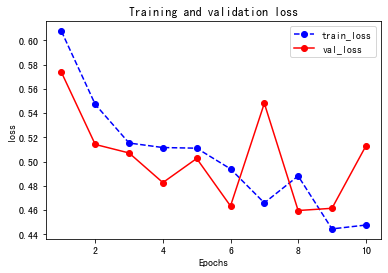

In [15]:
plot_metric(dfhistory, 'loss')

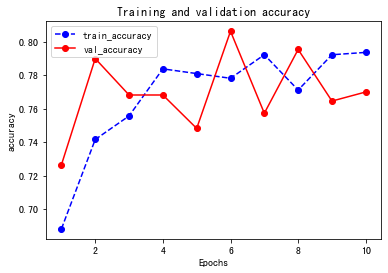

In [16]:
plot_metric(dfhistory, 'accuracy')

## 使用模型

In [17]:
# 预测概率
y_pred_probs = net(torch.tensor(x_test[0: 10]).float()).data
y_pred_probs

tensor([[0.1601],
        [0.4424],
        [0.1392],
        [0.2063],
        [0.7126],
        [0.2863],
        [0.8085],
        [0.3779],
        [0.9006],
        [0.2844]])

In [18]:
# 预测类别
y_pred = torch.where(y_pred_probs > 0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))
y_pred

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.]])

In [19]:
y_pred = torch.where(y_pred_probs > 0.5, 1, 0)
y_pred

tensor([[0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0]])

## 保存模型

### 保存模型参数

In [20]:
print(net.state_dict().keys())

odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias', 'linear3.weight', 'linear3.bias'])


In [21]:
# 保存模型参数

torch.save(net.state_dict(), "model/net_parameter.pkl")

net_clone = create_net()
net_clone.load_state_dict(torch.load("model/net_parameter.pkl"))

net_clone(torch.tensor(x_test[0: 10]).float()).detach()

tensor([[0.1601],
        [0.4424],
        [0.1392],
        [0.2063],
        [0.7126],
        [0.2863],
        [0.8085],
        [0.3779],
        [0.9006],
        [0.2844]])

### 保存完整模型(不推荐)

In [22]:
torch.save(net, 'model/net_model.pkl')
net_loaded = torch.load('model/net_model.pkl')
net_loaded(torch.tensor(x_test[0: 10]).float()).detach()

tensor([[0.1601],
        [0.4424],
        [0.1392],
        [0.2063],
        [0.7126],
        [0.2863],
        [0.8085],
        [0.3779],
        [0.9006],
        [0.2844]])